In [59]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import ast
import joblib
import re
import string
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Load the Datasets in


In [4]:
yelp_train_businesses = pd.read_csv("yelp_cleaned_csv_dataset/yelp_train_businesses.csv")
yelp_train_tips = pd.read_csv("yelp_cleaned_csv_dataset/yelp_train_tips.csv")
yelp_train_reviews = pd.read_csv("yelp_cleaned_csv_dataset/yelp_train_reviews.csv")

In [5]:
yelp_validate_businesses = pd.read_csv("yelp_cleaned_csv_dataset/yelp_validate_businesses.csv")
yelp_validate_tips = pd.read_csv("yelp_cleaned_csv_dataset/yelp_validate_tips.csv")
yelp_validate_reviews = pd.read_csv("yelp_cleaned_csv_dataset/yelp_validate_reviews.csv")

In [6]:
yelp_test_businesses = pd.read_csv("yelp_cleaned_csv_dataset/yelp_test_businesses.csv")
yelp_test_tips = pd.read_csv("yelp_cleaned_csv_dataset/yelp_test_tips.csv")
yelp_test_reviews = pd.read_csv("yelp_cleaned_csv_dataset/yelp_test_reviews.csv")

In [7]:
def frequency_dict(df): 
    df_attributes = dict(df['attributes'])
    attributes_counter = dict()
    for i in range(len(df_attributes)):
        real_dict_attributes = dict(ast.literal_eval(df_attributes[i]))
        for attribute in real_dict_attributes.keys():
            if attribute not in attributes_counter:
                attributes_counter[attribute] = 1
            else:
                attributes_counter[attribute] += 1

    attributes_counter = dict(sorted(attributes_counter.items(), key=lambda item: item[1], reverse=True))

    return attributes_counter



In [8]:
attributes_train_businesses = frequency_dict(yelp_train_businesses)
attributes_validate_business = frequency_dict(yelp_validate_businesses)
attributes_test_businesses = frequency_dict(yelp_test_businesses)

In [9]:
def retrieve_attribute_from_df(df, attribute):
    filtered_df = df[df['attributes'].str.contains(attribute)][['business_id', 'review_count', 'attributes']]
    df_attributes = dict(filtered_df['attributes'])
    
    attribute_values = []

    for key in df_attributes.keys():
        real_dict_attributes = dict(ast.literal_eval(df_attributes[key]))
        attribute_values.append(real_dict_attributes[attribute])

            
    filtered_df['attribute_value'] = attribute_values

    return filtered_df[filtered_df['attribute_value'] != 'None']

    

In [10]:
# Plan to Predict the Following Attributes
    # BusinessAcceptsCreditCards
    # RestaurantsTakeOut
    # RestaurantsReservations
    # GoodForKids
    # RestaurantsPriceRange2

## got the 5 most frequent attributes

In [11]:
yelp_train_businesses_priceRange2 = retrieve_attribute_from_df(yelp_train_businesses, 'RestaurantsPriceRange2')
yelp_validate_businesses_priceRange2 = retrieve_attribute_from_df(yelp_validate_businesses, 'RestaurantsPriceRange2')
yelp_test_businesses_priceRange2 = retrieve_attribute_from_df(yelp_test_businesses, 'RestaurantsPriceRange2')

In [12]:
yelp_train_businesses_takeOut = retrieve_attribute_from_df(yelp_train_businesses, 'RestaurantsTakeOut')
yelp_validate_businesses_takeOut = retrieve_attribute_from_df(yelp_validate_businesses, 'RestaurantsTakeOut')
yelp_test_businesses_takeOut = retrieve_attribute_from_df(yelp_test_businesses, 'RestaurantsTakeOut')


In [13]:
yelp_train_businesses_reservations = retrieve_attribute_from_df(yelp_train_businesses, 'RestaurantsReservations')
yelp_validate_businesses_reservations = retrieve_attribute_from_df(yelp_validate_businesses, 'RestaurantsReservations')
yelp_test_businesses_reservations = retrieve_attribute_from_df(yelp_test_businesses, 'RestaurantsReservations')

In [14]:
yelp_train_businesses_Kids = retrieve_attribute_from_df(yelp_train_businesses, 'GoodForKids')
yelp_validate_businesses_Kids = retrieve_attribute_from_df(yelp_validate_businesses, 'GoodForKids')
yelp_test_businesses_Kids = retrieve_attribute_from_df(yelp_test_businesses, 'GoodForKids')

In [15]:
yelp_train_businesses_creditCards = retrieve_attribute_from_df(yelp_train_businesses, 'BusinessAcceptsCreditCards')
yelp_validate_businesses_creditCards = retrieve_attribute_from_df(yelp_validate_businesses, 'BusinessAcceptsCreditCards')
yelp_test_businesses_creditCards = retrieve_attribute_from_df(yelp_test_businesses, 'BusinessAcceptsCreditCards')

In [16]:
# 3454698

# 5242692

In [17]:
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

yelp_train_tips['clean_text'] = yelp_train_tips.text.map(process_text)
yelp_validate_tips['clean_text'] = yelp_validate_tips.text.map(process_text)
yelp_test_tips['clean_text'] = yelp_test_tips.text.map(process_text)

# yelp_train_reviews['clean_text'] = yelp_train_reviews.text.map(process_text)
# yelp_validate_reviews['clean_text'] = yelp_validate_reviews.text.map(process_text)
# yelp_test_reviews['clean_text'] = yelp_test_reviews.text.map(process_text)


In [18]:
# yelp_train_reviews.to_csv("yelp_cleaned_csv_dataset/yelp_train_reviews.csv")
# yelp_validate_reviews.to_csv("yelp_cleaned_csv_dataset/yelp_validate_reviews.csv")
# yelp_test_reviews.to_csv("yelp_cleaned_csv_dataset/yelp_test_reviews.csv")

In [70]:
vec = CountVectorizer(
    ngram_range=(1, 3), 
    stop_words="english",
)

In [92]:
def build_model(df_train, df_validate, df_test, business_train_df, business_validate_df, business_test_df):
    yelp_filtered_train = df_train[df_train['business_id'].isin(business_train_df['business_id'])]
    yelp_filtered_validate = df_validate[df_validate['business_id'].isin(business_validate_df['business_id'])]
    yelp_filtered_test = df_test[df_test['business_id'].isin(business_test_df['business_id'])]
    
    X_train = vec.fit_transform(yelp_filtered_train.clean_text)
    X_validate = vec.transform(yelp_filtered_validate.clean_text)
    X_test = vec.transform(yelp_filtered_test.clean_text)

    yelp_filtered_train = yelp_filtered_train.merge(business_train_df[['business_id', 'attribute_value']], on = 'business_id', how = 'inner')
    yelp_filtered_validate = yelp_filtered_validate.merge(business_validate_df[['business_id', 'attribute_value']], on = 'business_id', how = 'inner')
    yelp_filtered_test = yelp_filtered_test.merge(business_test_df[['business_id', 'attribute_value']], on = 'business_id', how = 'inner')

    y_train = yelp_filtered_train.attribute_value
    y_validate = yelp_filtered_validate.attribute_value
    y_test = yelp_filtered_test.attribute_value


    # Hyper-parameter tuning for Multinomial NB (randomized search)
    param_grid = {
    "multinomialnb__alpha": [0.0001, 0.001, 0.1, 1, 10, 100]
    }

    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    pipe_nb = make_pipeline(
        nb
    )

    random_search = RandomizedSearchCV(pipe_nb, param_grid, cv=3, verbose=2, n_jobs=-1)  
    validate_search = random_search.fit(X_validate, y_validate)

    best_alpha_param = validate_search.best_params_

    nb.set_params(alpha = best_alpha_param['multinomialnb__alpha'])
    

    preds = nb.predict(X_test)
    

    print(accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

    return nb, y_test, preds


In [93]:
takeOut_model, takeOut_test, takeOut_preds = build_model(yelp_train_tips, yelp_validate_tips, yelp_test_tips, yelp_train_businesses_takeOut, yelp_validate_businesses_takeOut, yelp_test_businesses_takeOut)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/puttu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END ........................multinomialnb__alpha=0.0001; total time=   0.4s


/Users/puttu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/puttu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/puttu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/puttu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.war

[CV] END .............................multinomialnb__alpha=1; total time=   0.9s
[CV] END ............................multinomialnb__alpha=10; total time=   0.6s
[CV] END ............................multinomialnb__alpha=10; total time=   0.8s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   1.6s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   1.6s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.6s
[CV] END .........................multinomialnb__alpha=0.001; total time=   1.7s
[CV] END .........................multinomialnb__alpha=0.001; total time=   1.7s[CV] END .........................multinomialnb__alpha=0.001; total time=   1.7s

[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.6s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.7s
[CV] END .............................multinomialnb__alpha=1; total time=   1.7s
[CV] END ...................

In [94]:
priceRange_model, priceRange2_test, priceRange2_preds = build_model(yelp_train_tips, yelp_validate_tips, yelp_test_tips, yelp_train_businesses_priceRange2, yelp_validate_businesses_priceRange2, yelp_test_businesses_priceRange2)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ........................multinomialnb__alpha=0.0001; total time=   1.1s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   1.2s
[CV] END .........................multinomialnb__alpha=0.001; total time=   1.4s
[CV] END .........................multinomialnb__alpha=0.001; total time=   1.4s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   1.4s
[CV] END .........................multinomialnb__alpha=0.001; total time=   1.4s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.5s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.5s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.6s
[CV] END .............................multinomialnb__alpha=1; total time=   1.6s
[CV] END .............................multinomialnb__alpha=1; total time=   1.6s
[CV] END .............................multinomial

In [95]:
Kids_model, Kids_test, Kids_preds = build_model(yelp_train_tips, yelp_validate_tips, yelp_test_tips, yelp_train_businesses_Kids, yelp_validate_businesses_Kids, yelp_test_businesses_Kids)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ........................multinomialnb__alpha=0.0001; total time=   0.4s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   0.5s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   0.5s
[CV] END .........................multinomialnb__alpha=0.001; total time=   0.5s
[CV] END .........................multinomialnb__alpha=0.001; total time=   0.5s
[CV] END .........................multinomialnb__alpha=0.001; total time=   0.6s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   0.6s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   0.6s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   0.6s
[CV] END .............................multinomialnb__alpha=1; total time=   0.6s
[CV] END .............................multinomialnb__alpha=1; total time=   0.5s
[CV] END .............................multinomial

In [96]:
reservations_model, reservations_test, reservations_preds =  build_model(yelp_train_tips, yelp_validate_tips, yelp_test_tips, yelp_train_businesses_reservations, yelp_validate_businesses_reservations, yelp_test_businesses_reservations)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ........................multinomialnb__alpha=0.0001; total time=   0.4s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   0.5s
[CV] END .........................multinomialnb__alpha=0.001; total time=   0.5s
[CV] END .........................multinomialnb__alpha=0.001; total time=   0.5s
[CV] END .........................multinomialnb__alpha=0.001; total time=   0.5s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   0.5s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   0.5s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   0.5s
[CV] END .............................multinomialnb__alpha=1; total time=   0.5s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   0.5s
[CV] END .............................multinomialnb__alpha=1; total time=   0.5s
[CV] END .............................multinomial

In [97]:
creditCards_model, creditCards_test, creditCards_preds = build_model(yelp_train_tips, yelp_validate_tips, yelp_test_tips, yelp_train_businesses_creditCards, yelp_validate_businesses_creditCards, yelp_test_businesses_creditCards)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ........................multinomialnb__alpha=0.0001; total time=   0.5s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   1.1s
[CV] END .........................multinomialnb__alpha=0.001; total time=   1.4s
[CV] END ........................multinomialnb__alpha=0.0001; total time=   1.4s
[CV] END .........................multinomialnb__alpha=0.001; total time=   1.4s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.5s
[CV] END .........................multinomialnb__alpha=0.001; total time=   1.5s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.5s
[CV] END ...........................multinomialnb__alpha=0.1; total time=   1.5s
[CV] END .............................multinomialnb__alpha=1; total time=   1.5s
[CV] END .............................multinomialnb__alpha=1; total time=   1.5s
[CV] END .............................multinomial

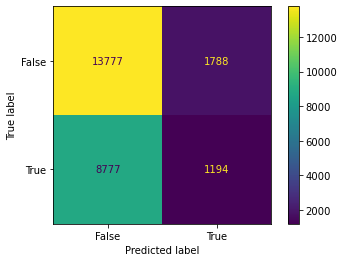

In [98]:
reservations_matrix = confusion_matrix(reservations_test, reservations_preds)
ConfusionMatrixDisplay(confusion_matrix = reservations_matrix, display_labels = [False, True]).plot()

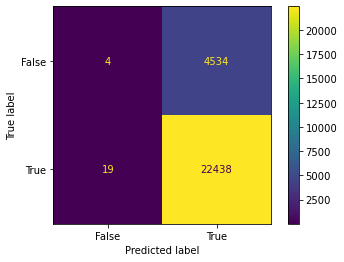

In [99]:
Kids_matrix = confusion_matrix(Kids_test, Kids_preds)
ConfusionMatrixDisplay(confusion_matrix = Kids_matrix, display_labels = [False, True]).plot()

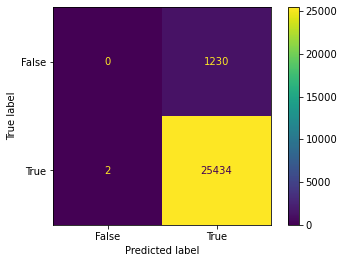

In [100]:
takeOut_matrix = confusion_matrix(takeOut_test, takeOut_preds)
ConfusionMatrixDisplay(confusion_matrix = takeOut_matrix, display_labels = [False, True]).plot()

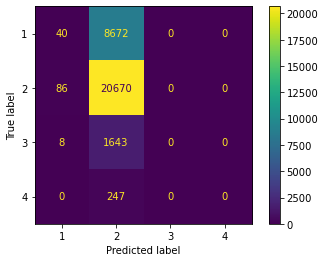

In [101]:
priceRange2_matrix = confusion_matrix(priceRange2_test, priceRange2_preds)
ConfusionMatrixDisplay(confusion_matrix = priceRange2_matrix, display_labels = [1, 2, 3, 4]).plot()

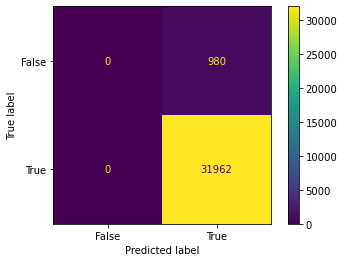

In [102]:
creditCards_matrix = confusion_matrix(creditCards_test, creditCards_preds)
ConfusionMatrixDisplay(confusion_matrix = creditCards_matrix, display_labels = [False, True]).plot()

In [ ]:
## Word2Vec


In [42]:
# Hyperparameters

creditCards_model.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [ ]:
yelp_test_businesses_priceRange2.groupby(['attribute_value'])['attribute_value'].agg('count')

In [ ]:
attributes_validate_business

In [ ]:
attributes_test_businesses

In [ ]:
attributes_train_businesses

In [ ]:
'''
Task 1:
Predict business attributes by using Review and Tip
textual information.
Something more interesting?
• Noise removal?
• Sampling?
• Extracting name entities and opinion from the text?
• Focusing on most useful reviews/tips?
• Sentiment scores can be useful?
'''

In [ ]:
# Part 1 - Predict business attributes by using Review and Tip textual information

''' 
You need to create your own training and testing sets
(e.g., for business has more than 50 reviews + tips and
more than 3 attributes); you may need to focus on
popular attributes
'''

In [ ]:
# Models - NLTK

# Hyperparameter Tuning

# Error Histograms?